# Mounting Content from Google Drive

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary libraries

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import datasets


Labels in dataset:
*   label 0: neutral
*   label 1: anti-vax
*   label 2: pro-vax







In [9]:
# train set
Train_set_Location = r'/content/vaccine_train_set.csv' 

# validation set
Validation_set_Location = r'/content/vaccine_validation_set.csv'  

df_train = pd.read_csv(Train_set_Location, index_col=0)
df_test = pd.read_csv(Validation_set_Location, index_col=0)
df_train.head(5)

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [10]:
print(df_train.shape)
print(df_test.shape)

(15976, 2)
(2282, 2)


# Clean up the data


In [11]:
# function for cleaning tweet from url/sign/emojis
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub("@|#|\":", "", tweet)    # Remove my chars : @, #, ": 
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    # tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \   
        #  if w.lower() in words or not w.isalpha())
    return tweet

In [13]:
import nltk
!pip install emoji --upgrade    # install emoji library for cleaning data
import emoji
import re

# Drop the rows where at least one element is missing
df_train.dropna()
df_test.dropna()

# Convert all tweets to lowercase
df_train['tweet'] = df_train['tweet'].apply(lambda x : x.lower())
df_test['tweet'] = df_test['tweet'].apply(lambda x : x.lower())

# Remove punctuations
df_train['tweet'] = df_train['tweet'].apply(lambda x : x.replace('[^\w\s]', ""))
df_test['tweet'] = df_test['tweet'].apply(lambda x : x.replace('[^\w\s]', ""))

# Clean the datasets from hashtags/urls/etc
df_train['tweet'] = df_train['tweet'].map(lambda x: cleaner(x))
df_test['tweet'] = df_test['tweet'].map(lambda x: cleaner(x))

# remove emojis
df_train['tweet'] = df_train['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
df_test['tweet'] = df_test['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))


df_train.head(5)

,tweet,label
0,sip n shop come thru right now marjais popular...,0
1,i don't know about you but my family and i wil...,1
2,immunizations should be mandatory. period. in ...,2
3,president obama spoke in favor of vaccination ...,0
4,arizona monitoring hundreds for measles linked...,0


0    7458
2    6445
1    2073
Name: label, dtype: int64


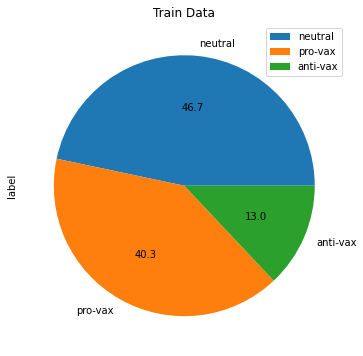

In [14]:
 # check the percentages of train set
label = df_train['label'].value_counts()
check_df_train = label.to_frame()
plot = check_df_train.plot(kind='pie', y='label', labels=['neutral', 'pro-vax', 'anti-vax'], autopct='%.1f', figsize = (8, 6), title='Train Data')
print(label)

0    1065
2     921
1     296
Name: label, dtype: int64


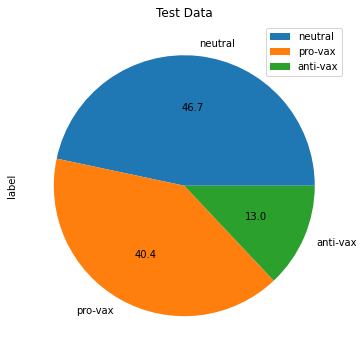

In [15]:
 # check the percentages of test set
label = df_test['label'].value_counts()
check_df_test = label.to_frame()
plot = check_df_test.plot(kind='pie', y='label', labels=['neutral', 'pro-vax', 'anti-vax'], autopct='%.1f', figsize = (8, 6), title='Test Data')
print(label)

# Target

In [16]:
train_label = np.asarray(df_train['label'])
test_label = np.asarray(df_test['label'])

train_label.shape, test_label.shape

((15976,), (2282,))

# Softmax Regression

In [17]:
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import precision_score, recall_score, f1_score  
from sklearn import metrics   

In [18]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+|__|_*', '', text) # remove numbers , '__' and other useless characters
    return text

## TfidfVectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import re

my_words = 'https http'.split()
my_stopwords = ENGLISH_STOP_WORDS.union(my_words)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.117, preprocessor=preprocess_text)


tfidf_train = tfidf_vectorizer.fit_transform(df_train['tweet'])
tfidf_test = tfidf_vectorizer.transform(df_test['tweet'])
tfidf_train_test = tfidf_vectorizer.transform(df_train['tweet'])


In [20]:
# Prepare the model
model_LR = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Fitting our model
model_LR.fit(tfidf_train, train_label)

# Predict the labels on the test set.
predictions_LR = model_LR.predict(tfidf_test)

### Score (recall, precision, f1_score)

Printing scores for predictions on the test set.

Average accuracy using Logistic Regression and precision measure: 66.93%
Average accuracy using Logistic Regression and f1 measure: 66.62%
Average accuracy using Logistic Regression and recall measure: 68.19%

 Predictions for Logistic Regression


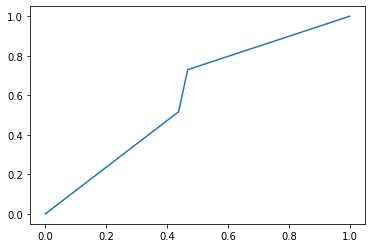

In [21]:
print("Printing scores for predictions on the test set.\n")

precision_score_test = precision_score(test_label, predictions_LR, average='weighted' )     
print ("Average accuracy using Logistic Regression and precision measure: {}%".format(round(precision_score_test*100,2))) 

f1_score_test = f1_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and f1 measure: {}%".format(round(f1_score_test*100,2)))

recall_score_test = recall_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and recall measure: {}%".format(round(recall_score_test*100,2)))


fpr, tpr, thresholds = metrics.roc_curve(test_label, predictions_LR, pos_label=1)
print("\n", "Predictions for Logistic Regression")
plt.plot(fpr, tpr)
plt.show()

### Learning Curves

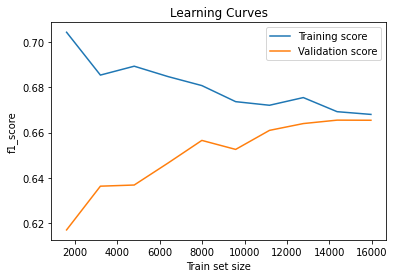

In [22]:
from sklearn.metrics import mean_squared_error as mse

train_errors=[]
val_errors=[]
train_size = tfidf_train.get_shape()[0]

step = int(train_size/10)  # 10% of the train set

for i in range(step, train_size, step):
    model_LR.fit(tfidf_train[:i], train_label[:i])
    train_preds = model_LR.predict(tfidf_train[:i])
    val_preds = model_LR.predict(tfidf_test)
    # train_errors.append(mse(train_preds, train_label[:i]))    # mse
    train_errors.append(f1_score(train_label[:i], train_preds, average='weighted'))  # f1_score
    # val_errors.append(mse(val_preds, test_label))             # mse
    val_errors.append(f1_score(test_label, val_preds, average='weighted'))    # f1_score

plt.plot(range(step, train_size, step), train_errors, label='Training score')
plt.plot(range(step, train_size, step), val_errors, label='Validation score')
plt.title('Learning Curves')    
plt.xlabel('Train set size')
plt.ylabel('f1_score')
plt.legend()
plt.show()

### confusion matrix


Test confusion_matrix


Text(33.0, 0.5, 'True')

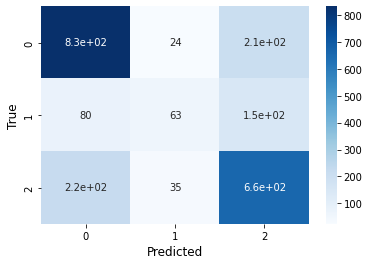

In [23]:
# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_label, predictions_LR)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

## CountVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

my_words = 'https http'.split()
my_stopwords = ENGLISH_STOP_WORDS.union(my_words)

countVectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.117, preprocessor=preprocess_text)

bow_train = countVectorizer.fit_transform(df_train['tweet'])
bow_test = countVectorizer.transform(df_test['tweet'])

In [28]:
# Prepare the model
model_LR = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Fitting our model
model_LR.fit(bow_train, train_label)

# Predict the labels on the test set.
predictions_LR = model_LR.predict(bow_test)

### Score (recall, precision, f1_score)

Printing scores for predictions on the test set.

Average accuracy using Logistic Regression and precision measure: 65.96%
Average accuracy using Logistic Regression and f1 measure: 65.83%
Average accuracy using Logistic Regression and recall measure: 67.53%

 Predictions for Logistic Regression


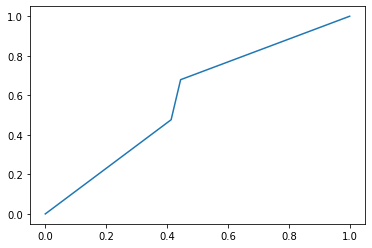

In [29]:
print("Printing scores for predictions on the test set.\n")

precision_score_test = precision_score(test_label, predictions_LR, average='weighted' )     
print ("Average accuracy using Logistic Regression and precision measure: {}%".format(round(precision_score_test*100,2))) 

f1_score_test = f1_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and f1 measure: {}%".format(round(f1_score_test*100,2)))

recall_score_test = recall_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and recall measure: {}%".format(round(recall_score_test*100,2)))


fpr, tpr, thresholds = metrics.roc_curve(test_label, predictions_LR, pos_label=1)
print("\n", "Predictions for Logistic Regression")
plt.plot(fpr, tpr)
plt.show()

### Learning Curves

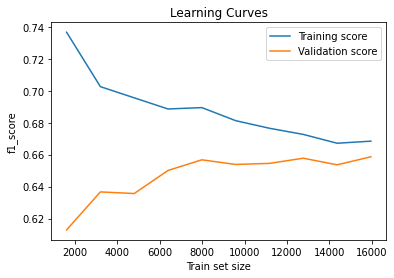

In [30]:
from sklearn.metrics import mean_squared_error as mse

train_errors=[]
val_errors=[]
n_iter = bow_train.get_shape()[0]

step = int(n_iter/10) # 10% of the train set

for i in range(step, n_iter, step):
    model_LR.fit(bow_train[:i], train_label[:i])
    train_preds=model_LR.predict(bow_train[:i])
    val_preds=model_LR.predict(bow_test)
    # train_errors.append(mse(train_preds, train_label[:i]))    # mse
    train_errors.append(f1_score(train_label[:i], train_preds, average='weighted'))  # f1_score
    # val_errors.append(mse(val_preds, test_label))             # mse
    val_errors.append(f1_score(test_label, val_preds, average='weighted'))    # f1_score

plt.plot(range(step, n_iter, step), train_errors, label='Training score')
plt.plot(range(step, n_iter, step), val_errors, label='Validation score')
plt.title('Learning Curves')    
plt.xlabel('Train set size')
plt.ylabel('f1_score')
plt.legend()
plt.show()

### confusion matrix


Test confusion_matrix


Text(33.0, 0.5, 'True')

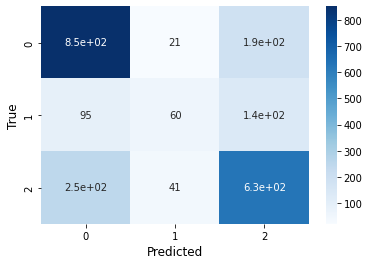

In [31]:
# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_label, predictions_LR)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

## HashingVectorizer

In [32]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

# my_n_features = int(train_label.shape[0]/2) # get the half number of features

hashVectorizer = HashingVectorizer(ngram_range=(1, 2), n_features=2**8, stop_words=my_stopwords, preprocessor=preprocess_text) 
# oso paei panw apo 2**10 h apoklish auxanete
# oso paei katw apo 2**6 tote ginete to idio

hash_train = hashVectorizer.fit_transform(df_train['tweet'])
hash_test = hashVectorizer.transform(df_test['tweet'])


In [33]:
# Prepare the model
model_LR = LogisticRegression(multi_class='multinomial', max_iter=1000)

# Fitting our model
model_LR.fit(hash_train, train_label)

# Predict the labels on the test set.
predictions_LR = model_LR.predict(hash_test)

### Score (recall, precision, f1_score)

Printing scores for predictions on the test set.

Average accuracy using Logistic Regression and precision measure: 59.7%
Average accuracy using Logistic Regression and f1 measure: 59.15%
Average accuracy using Logistic Regression and recall measure: 61.35%

 Predictions for Logistic Regression


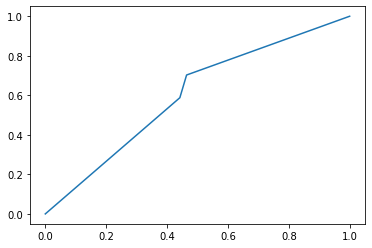

In [34]:
print("Printing scores for predictions on the test set.\n")

precision_score_test = precision_score(test_label, predictions_LR, average='weighted' )     
print ("Average accuracy using Logistic Regression and precision measure: {}%".format(round(precision_score_test*100,2))) 

f1_score_test = f1_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and f1 measure: {}%".format(round(f1_score_test*100,2)))

recall_score_test = recall_score(test_label, predictions_LR, average='weighted')
print ("Average accuracy using Logistic Regression and recall measure: {}%".format(round(recall_score_test*100,2)))


fpr, tpr, thresholds = metrics.roc_curve(test_label, predictions_LR, pos_label=1)
print("\n", "Predictions for Logistic Regression")
plt.plot(fpr, tpr)
plt.show()

### Learning Curves

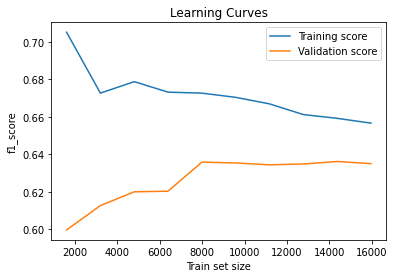

In [35]:
from sklearn.metrics import mean_squared_error as mse

train_errors=[]
val_errors=[]
n_iter = hash_train.get_shape()[0]

step = int(n_iter/10)   # 10% of the train set

for i in range(step, n_iter, step):
    model_LR.fit(hash_train[:i], train_label[:i])
    train_preds=model_LR.predict(hash_train[:i])
    val_preds=model_LR.predict(hash_test)
    # train_errors.append(mse(train_preds, train_label[:i]))    # mse
    train_errors.append(f1_score(train_preds, train_label[:i],  average='weighted'))  # f1_score
    # val_errors.append(mse(val_preds, test_label))             # mse
    val_errors.append(f1_score(val_preds, test_label,  average='weighted'))    # f1_score

plt.plot(range(step, n_iter, step), train_errors, label='Training score')
plt.plot(range(step, n_iter, step), val_errors, label='Validation score')
plt.title('Learning Curves')    
plt.xlabel('Train set size')
plt.ylabel('f1_score')
plt.legend()
plt.show()

### confusion matrix


Test confusion_matrix


Text(33.0, 0.5, 'True')

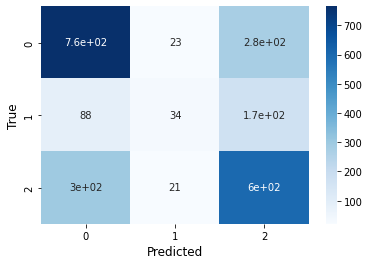

In [36]:
# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_label, predictions_LR)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)